<a href="https://colab.research.google.com/github/vfrantc/quaternion_neurons/blob/main/comparison_all_neurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn
!pip install git+https://github.com/TParcollet/Quaternion-Neural-Networks.git

Found existing installation: scikit-learn 1.2.1
Uninstalling scikit-learn-1.2.1:
  Successfully uninstalled scikit-learn-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.2.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TParcollet/Quaternion-Neural-Networks.git to /tmp/pip-req-build-8z7iu1x0
  Running command git clone --filter=blob:none --quiet https://github.com/TParcollet/Quaternion-Neural-Networks.git /tmp/pip-req-build-8z7iu1x0
  Resolved https://github.com/TParcollet/Quaternion-Neural-Networks.git to commit f8de5d5e5a3f9c694a0d62cffc64ec4ccdffd1bc
  Preparing metadata (setup.py) ... done


In [2]:
from collections import defaultdict
import math
import sys
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import numpy as np
from   numpy.random import RandomState
import torch
from   torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from   torch.nn.parameter import Parameter
from   torch.nn import Module

In [3]:
from core_qnn.quaternion_ops import quaternion_init
from core_qnn.quaternion_ops import unitary_init
from core_qnn.quaternion_ops import affect_init
from core_qnn.quaternion_layers import QuaternionLinear
from core_qnn.quaternion_layers import QuaternionLinearAutograd

# Prepare data, training proc, etc. 

**Storage to save results of all the models**

In [11]:
registry = dict()

### Dataset

In [12]:
def load_dataset():
  iris = load_iris()
  X = iris['data']
  y = iris['target']
  names = iris['target_names']
  feature_names = iris['feature_names']

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)
  return X_train, X_test, y_train, y_test, X_scaled, y

In [13]:
X_train, X_test, y_train, y_test, X_scaled, y = load_dataset()

# Train

In [22]:
def train(model, epochs=200, lr=0.01):
  global X_train, X_test, y_train, y_test
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  loss_fn   = nn.CrossEntropyLoss()

  # We use external version loaded before
  X_train_ = Variable(torch.from_numpy(X_train)).float()
  y_train_ = Variable(torch.from_numpy(y_train)).long()
  X_test_  = Variable(torch.from_numpy(X_test)).float()
  y_test_  = Variable(torch.from_numpy(y_test)).long()

  loss_list     = np.zeros((epochs,))
  accuracy_list = np.zeros((epochs,))

  for epoch in tqdm(range(epochs)):
      y_pred = model(X_train_)
      loss = loss_fn(y_pred, y_train_)
      loss_list[epoch] = loss.item()
      
      # Zero gradients
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      with torch.no_grad():
          y_pred = model(X_test_)
          correct = (torch.argmax(y_pred, dim=1) == y_test_).type(torch.FloatTensor)
          accuracy_list[epoch] = correct.mean()
  return loss_list, accuracy_list

In [23]:
def predict(model, X):
  X = Variable(torch.from_numpy(X)).float()
  with torch.no_grad():
    y = model(X)
  y = np.argmax(y.detach(), axis=1)
  return y

### Drawings

In [28]:
def evaluate(model_cls, bb = ((20, 25), (23, 24), (25, 26), (30, 25))):
  global registry, X_train, X_test, y_train, y_test, X_scaled, y
  print('Evaluate {}'.format(model_cls.__name__))

  # train the model

  model     = model_cls(X_train.shape[1])
  loss_list, accuracy_list = train(model, epochs=200, lr=0.01)

  y_pred = predict(model, X_test)

  # display the clas
  print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

  perf = dict()
  perf['accuracy'] = accuracy_score(y_test, y_pred, normalize=False)  
  perf['precision'], perf['recall'], perf['fscore'], _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

  # Training process
  fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
  ax1.plot(accuracy_list)
  ax1.set_ylabel("validation accuracy")
  ax2.plot(loss_list)
  ax2.set_ylabel("validation loss")
  ax2.set_xlabel("epochs");

  # ROC - curve
  plt.figure(figsize=(10, 10))
  plt.plot([0, 1], [0, 1], 'k--')
  enc = OneHotEncoder()
  Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

  with torch.no_grad():
      y_pred = model(Variable(torch.from_numpy(X_test)).float()).numpy()
      fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())

  perf['auc'] = auc(fpr, tpr)
  registry[model_cls.__name__] = perf

  plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend();

  feature_1, feature_2, feature_3, feature_4 = np.meshgrid(
    np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max()),
    np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max()),
    np.linspace(X_scaled[:, 2].min(), X_scaled[:, 2].max()),
    np.linspace(X_scaled[:, 3].min(), X_scaled[:, 3].max())
  )

  grid = np.vstack([feature_1.ravel(), feature_2.ravel(), feature_3.ravel(), feature_4.ravel()]).T
  grid = torch.tensor(grid, dtype=torch.float32)
  prediction = model(grid).detach().numpy()
  prediction = np.argmax(prediction, axis=1)

  for (sl1, sl2) in bb:
    print('{} - {}'.format(sl1, sl2))
    y_pred = np.reshape(prediction, feature_1.shape)
    display = DecisionBoundaryDisplay(xx0=feature_1[:, :, sl1, sl1], xx1=feature_2[:, :, sl1, sl1], response=y_pred[:, :, sl1, sl1])
    display.plot()
    display.ax_.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolor="black")
    display.ax_.set_xlabel('petal length (scaled)')
    display.ax_.set_ylabel('petal width (scaled)')
    plt.show()

    y_pred = np.reshape(prediction, feature_1.shape)
    display = DecisionBoundaryDisplay(xx0=feature_3[sl2, sl2, :, :], xx1=feature_4[sl2, sl2, :, :], response=y_pred[sl2, sl2, :, :])
    display.plot()
    display.ax_.scatter(X_scaled[:, 2], X_scaled[:, 3], c=y, edgecolor="black")
    display.ax_.set_xlabel('sepal length (scaled)')
    display.ax_.set_ylabel('sepal width (scaled)')
    plt.show()

# Real neuron

**One neuron**

Evaluate RealThreeNeuronsOneLayer


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.00      0.00      0.00         8
           2       0.50      1.00      0.67         8

    accuracy                           0.73        30
   macro avg       0.50      0.67      0.56        30
weighted avg       0.60      0.73      0.64        30

20 - 25


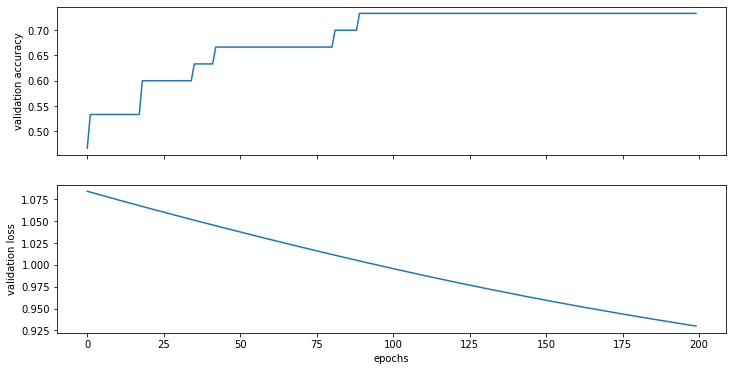

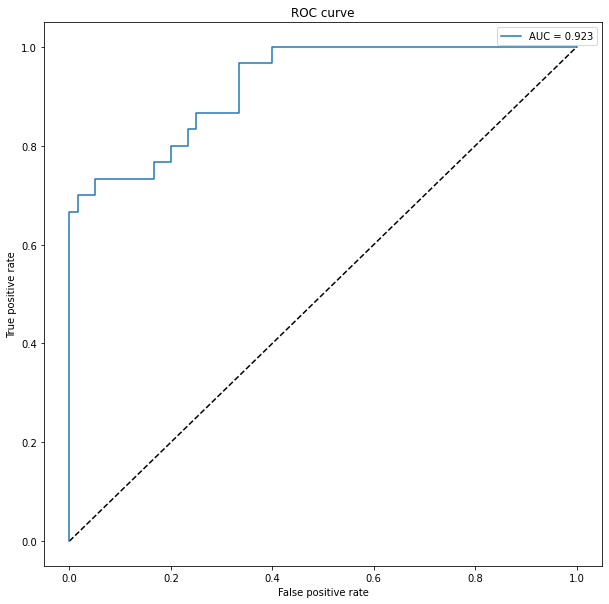

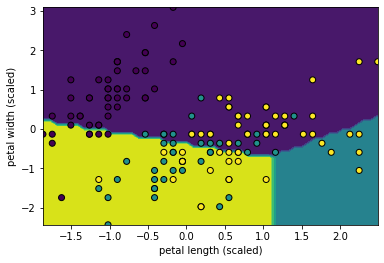

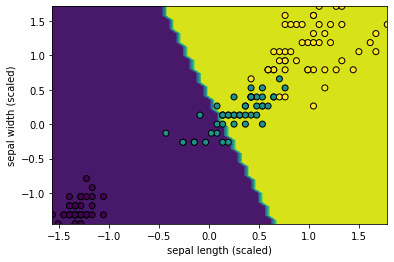

23 - 24


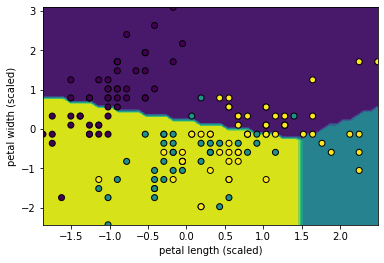

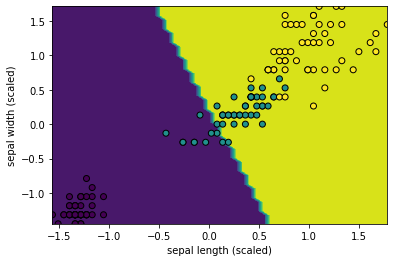

25 - 26


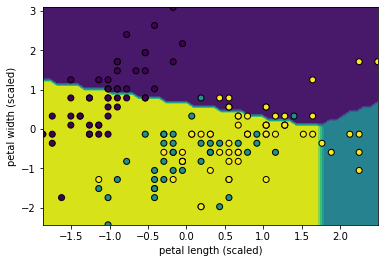

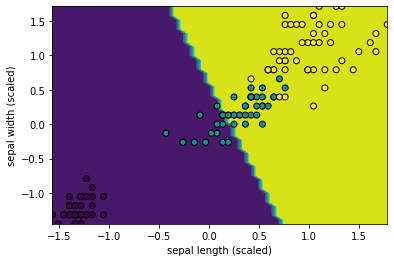

30 - 25


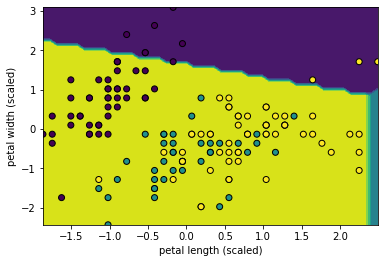

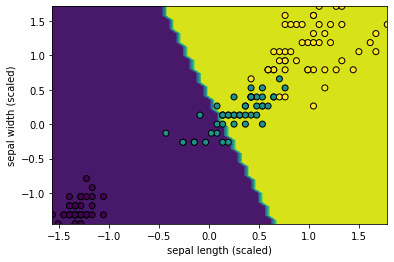

In [31]:
class RealThreeNeuronsOneLayer(nn.Module):
    def __init__(self, input_dim):
        super(RealThreeNeuronsOneLayer, self).__init__()
        self.layer1 = nn.Linear(input_dim, 3)
        
    def forward(self, x):
        x = F.softmax(self.layer1(x), dim=1)
        return x

evaluate(RealThreeNeuronsOneLayer)

**Two layers with one neuron**

Evaluate Real6NeuronsTwoLayers


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        14
           1       0.00      0.00      0.00         8
           2       0.60      0.75      0.67         8

    accuracy                           0.67        30
   macro avg       0.45      0.58      0.51        30
weighted avg       0.50      0.67      0.57        30

20 - 25


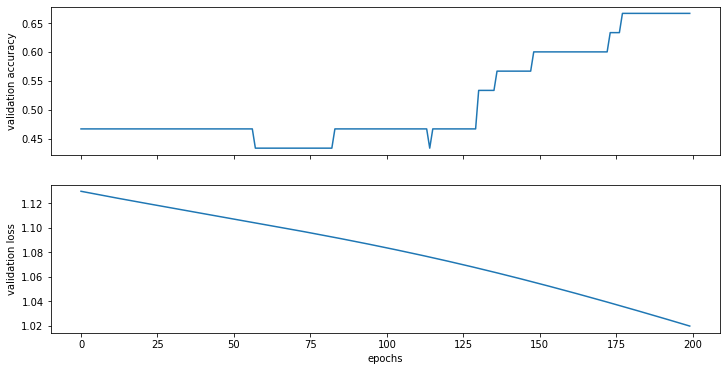

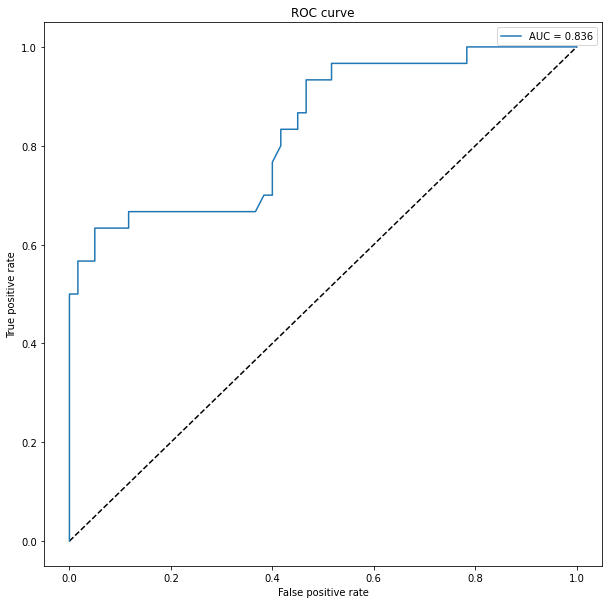

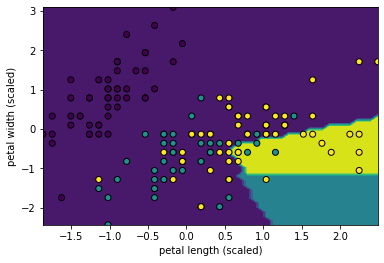

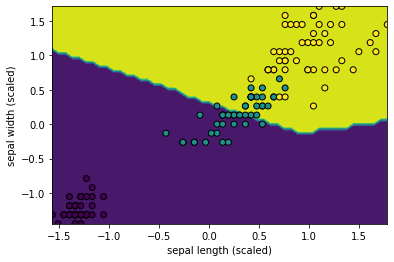

23 - 24


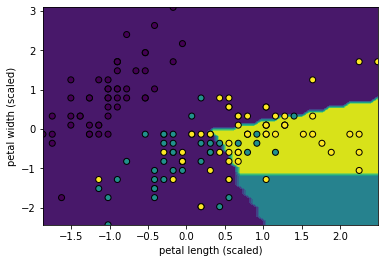

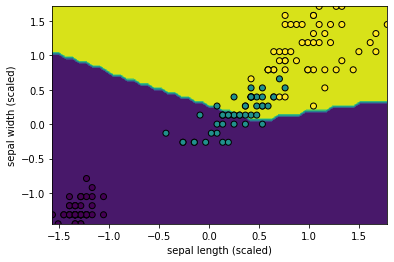

25 - 26


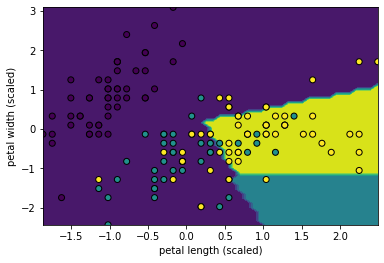

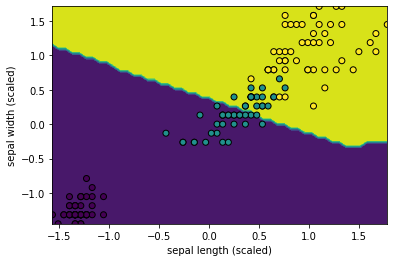

30 - 25


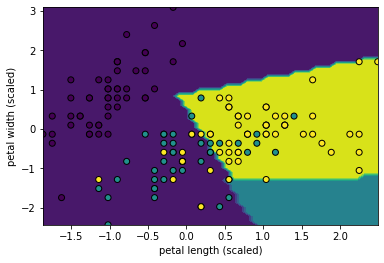

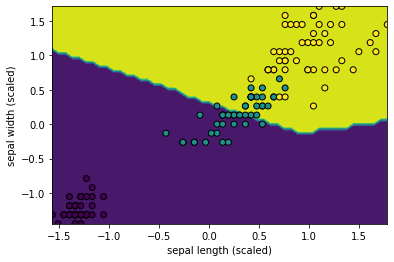

In [32]:
class Real6NeuronsTwoLayers(nn.Module):
    def __init__(self, input_dim):
        super(Real6NeuronsTwoLayers, self).__init__()
        self.layer1 = nn.Linear(input_dim, 3)
        self.layer2 = nn.Linear(3, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.softmax(self.layer2(x), dim=1)
        return x

evaluate(Real6NeuronsTwoLayers)

**3 layer mlp**

Evaluate Real3MLP


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.71      0.62      0.67         8
           2       0.70      0.88      0.78         8

    accuracy                           0.83        30
   macro avg       0.80      0.81      0.80        30
weighted avg       0.84      0.83      0.83        30

20 - 25


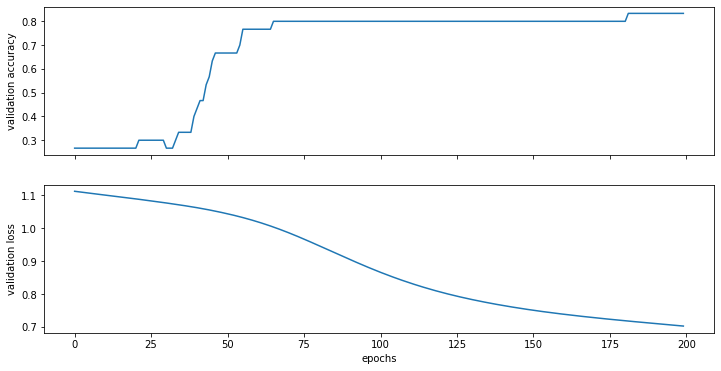

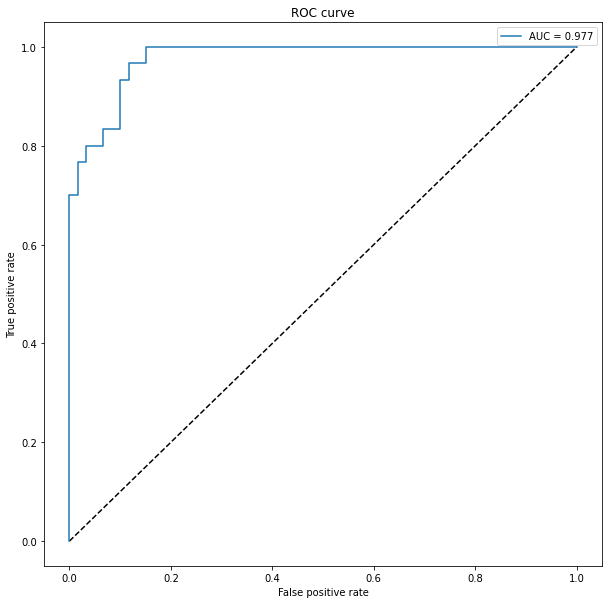

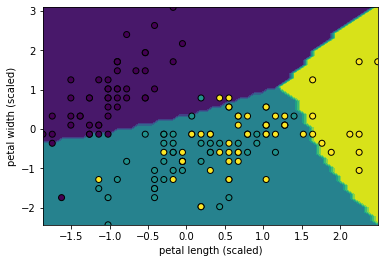

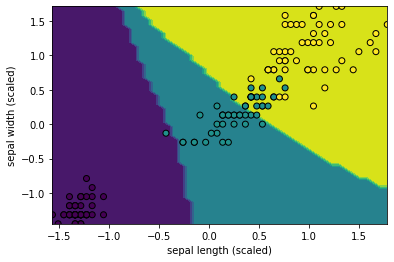

23 - 24


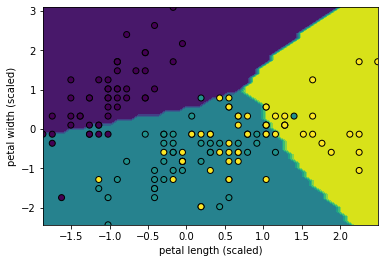

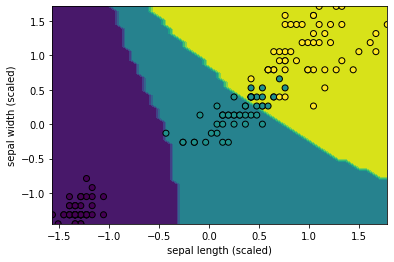

25 - 26


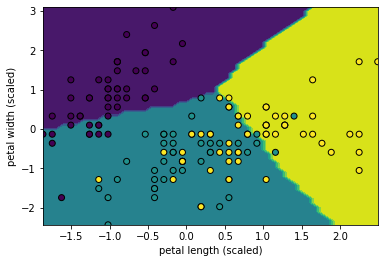

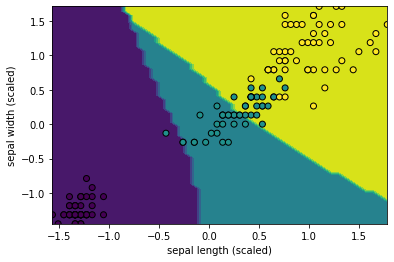

30 - 25


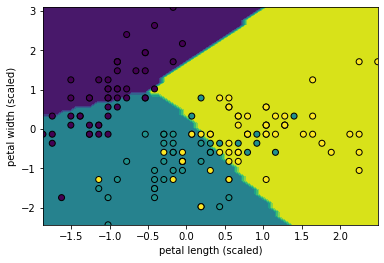

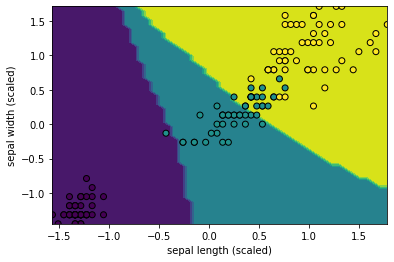

In [35]:
class Real3MLP(nn.Module):
    def __init__(self, input_dim):
        super(Real3MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, 3)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

evaluate(Real3MLP)

In [36]:
import pprint
pprint.pprint(registry)

{'Real3MLP': {'accuracy': 25,
              'auc': 0.9766666666666666,
              'fscore': 0.8345679012345679,
              'precision': 0.8438095238095239,
              'recall': 0.8333333333333334},
 'Real6NeuronsTwoLayers': {'accuracy': 20,
                           'auc': 0.8355555555555555,
                           'fscore': 0.5737373737373737,
                           'precision': 0.503859649122807,
                           'recall': 0.6666666666666666},
 'RealOneNeuron': {'accuracy': 24,
                   'auc': 0.9261111111111111,
                   'fscore': 0.7866666666666667,
                   'precision': 0.8222222222222223,
                   'recall': 0.8},
 'RealThreeNeuronsOneLayer': {'accuracy': 22,
                              'auc': 0.9227777777777777,
                              'fscore': 0.6444444444444444,
                              'precision': 0.6,
                              'recall': 0.7333333333333333}}


In [ ]:
#

# Quaternion

**one neuron**

Evaluate QuaternionOneNeuron


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.10      0.07      0.08        14
           1       0.07      0.12      0.09         8
           2       0.40      0.25      0.31         8

    accuracy                           0.13        30
   macro avg       0.19      0.15      0.16        30
weighted avg       0.17      0.13      0.14        30

20 - 25


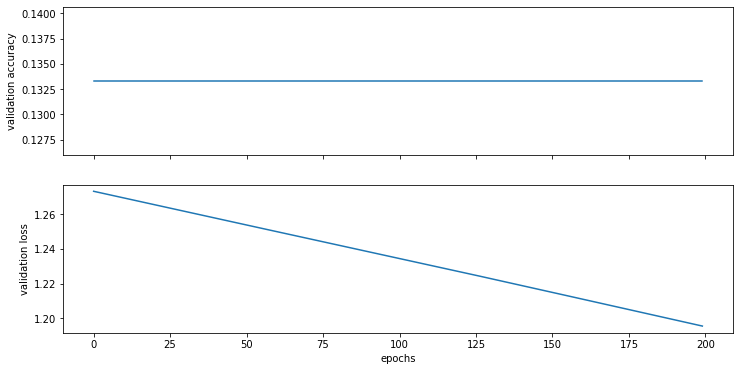

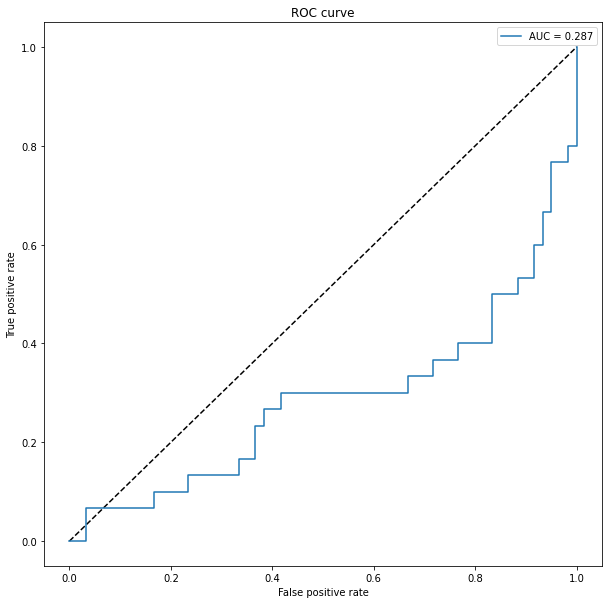

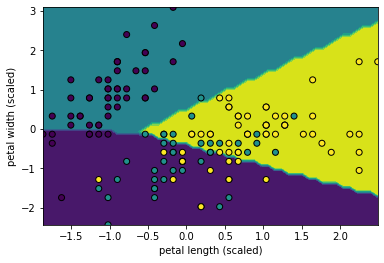

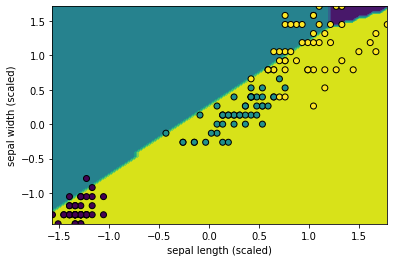

23 - 24


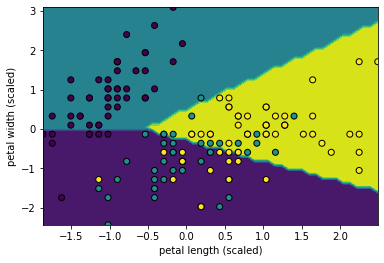

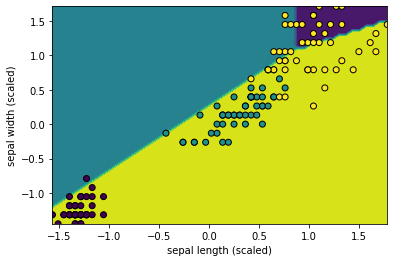

25 - 26


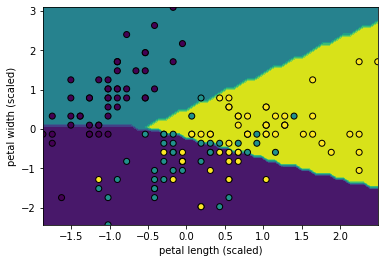

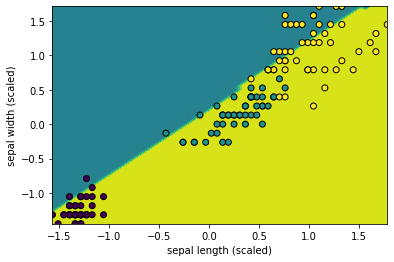

30 - 25


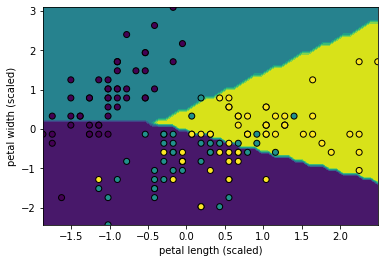

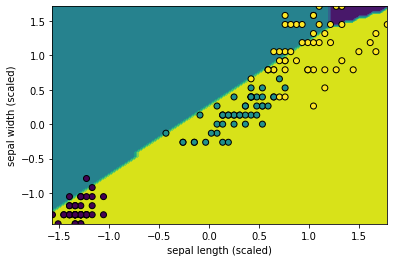

Evaluate QuaternionTwoLayer


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.70      1.00      0.82        14
           1       1.00      0.12      0.22         8
           2       0.56      0.62      0.59         8

    accuracy                           0.67        30
   macro avg       0.75      0.58      0.54        30
weighted avg       0.74      0.67      0.60        30

20 - 25


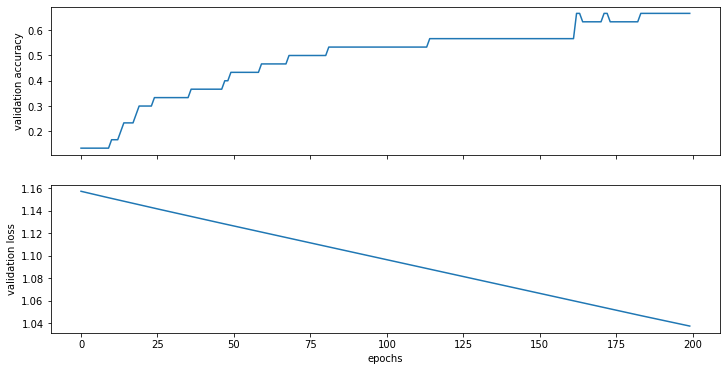

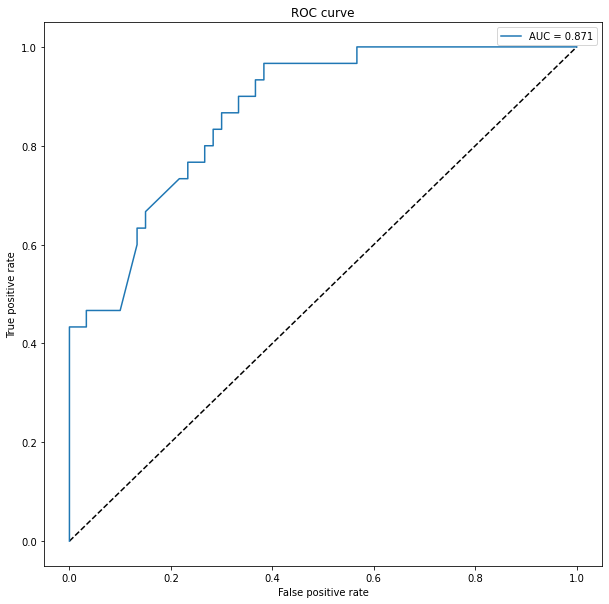

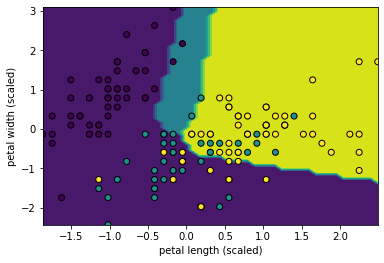

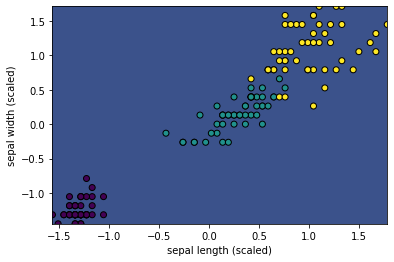

23 - 24


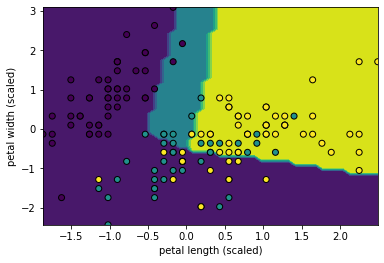

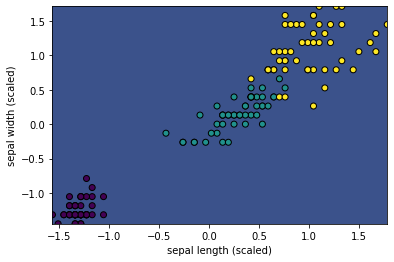

25 - 26


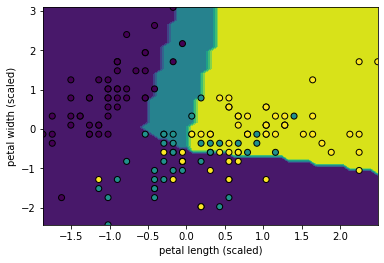

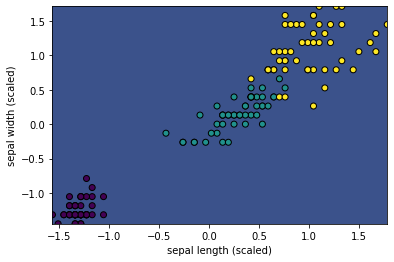

30 - 25


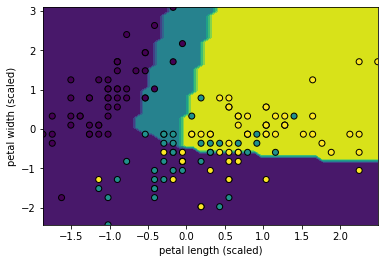

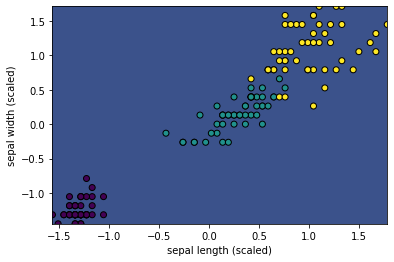

Evaluate Quaternion3MLP


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.86      0.75      0.80         8
           2       0.80      1.00      0.89         8

    accuracy                           0.90        30
   macro avg       0.89      0.89      0.88        30
weighted avg       0.91      0.90      0.90        30

20 - 25


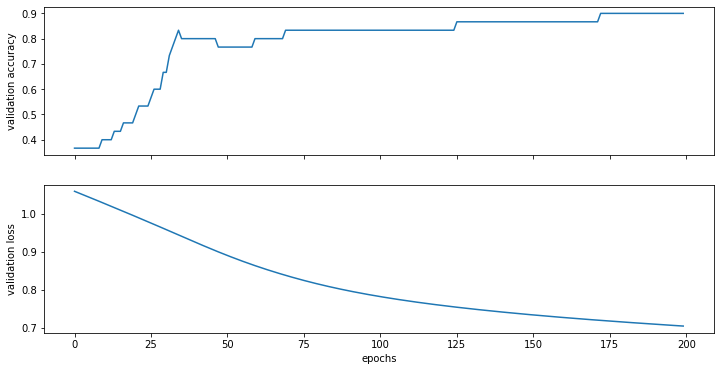

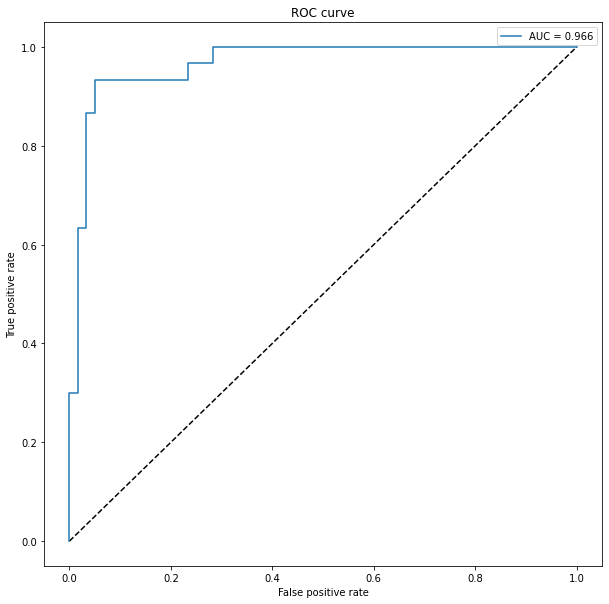

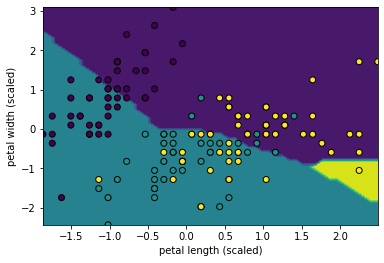

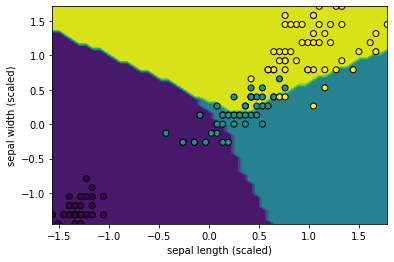

23 - 24


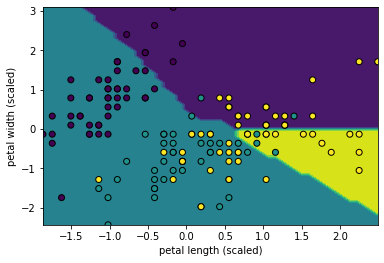

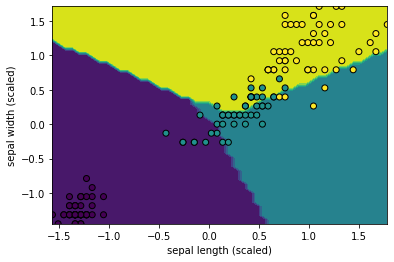

25 - 26


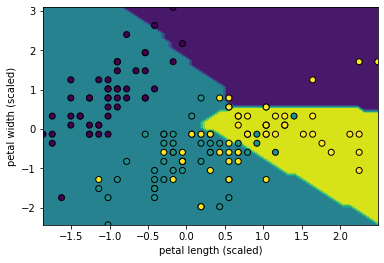

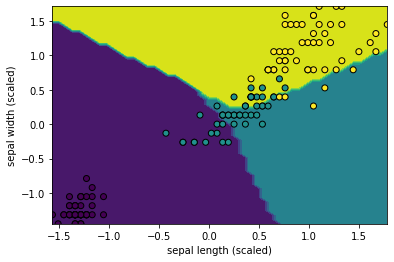

30 - 25


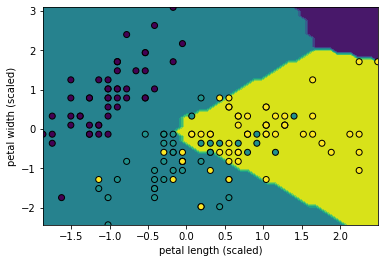

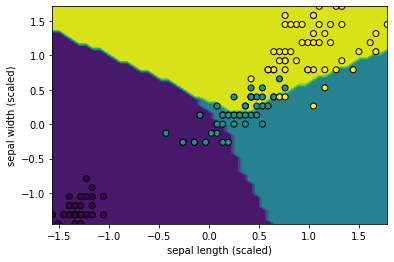

In [39]:
class QuaternionOneNeuron(nn.Module):
    def __init__(self, input_dim):
        super(QuaternionOneNeuron, self).__init__()
        self.layer1 = QuaternionLinear(input_dim, 4, bias=True)
        self.layer1.reset_parameters()
        
    def forward(self, x):
        x = F.softmax(self.layer1(x), dim=1)
        return x[:, 1:]

class QuaternionTwoLayer(nn.Module):
    def __init__(self, input_dim):
        super(QuaternionTwoLayer, self).__init__()
        self.layer1 = QuaternionLinear(input_dim, 4, bias=True)
        self.layer2 = QuaternionLinear(4, 4, bias=True)
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.softmax(self.layer2(x), dim=1)
        return x[:, 1:]

class Quaternion3MLP(nn.Module):
    def __init__(self, input_dim):
        super(Quaternion3MLP, self).__init__()
        self.layer1 = QuaternionLinear(input_dim, 16, bias=True)
        self.layer2 = QuaternionLinear(16, 16, bias=True)
        self.layer3 = QuaternionLinear(16, 4, bias=True)
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()
        self.layer3.reset_parameters()
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x[:, 1:]

evaluate(QuaternionOneNeuron)
evaluate(QuaternionTwoLayer)
evaluate(Quaternion3MLP)

# Tessarrine

Evaluate TessarineOneNeuron


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.50      0.25      0.33         8
           2       0.50      0.75      0.60         8

    accuracy                           0.73        30
   macro avg       0.67      0.67      0.64        30
weighted avg       0.73      0.73      0.72        30

20 - 25


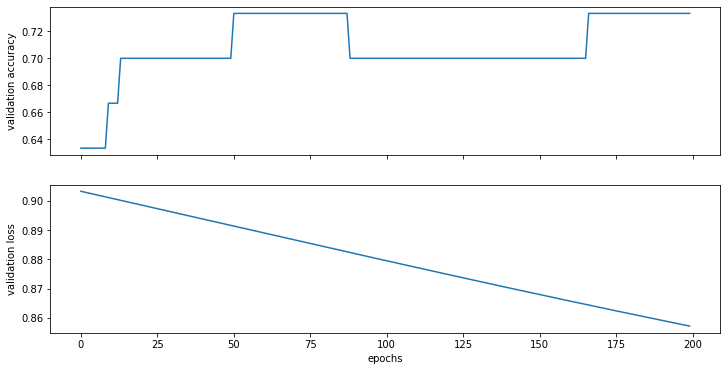

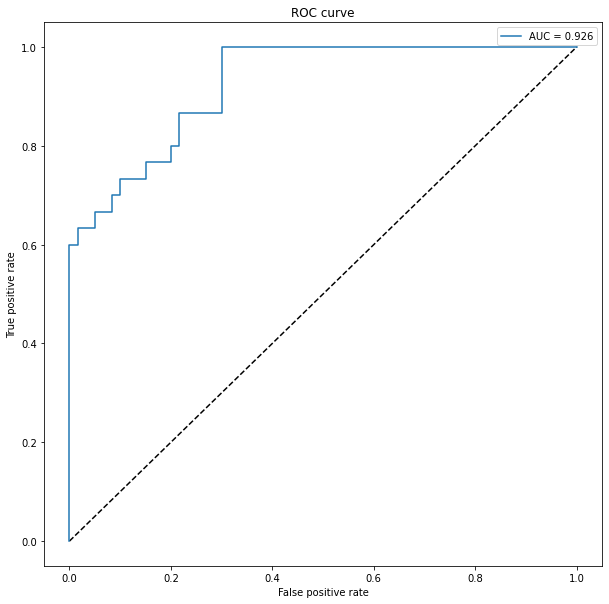

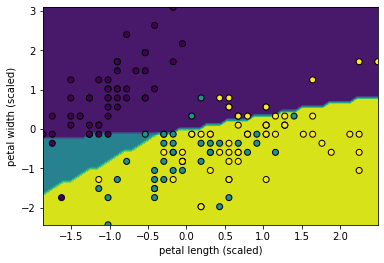

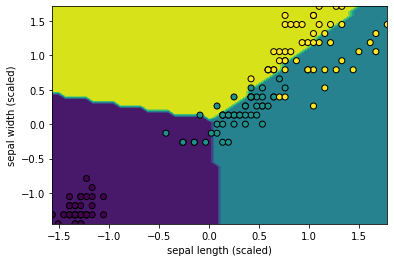

23 - 24


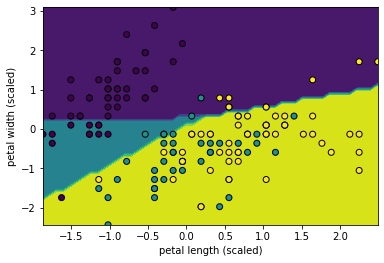

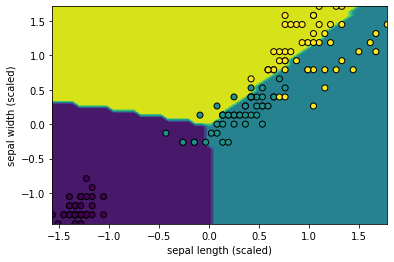

25 - 26


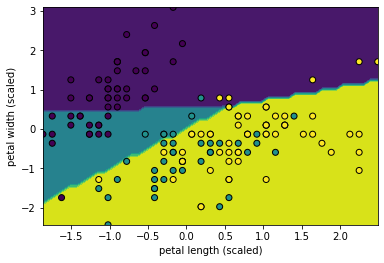

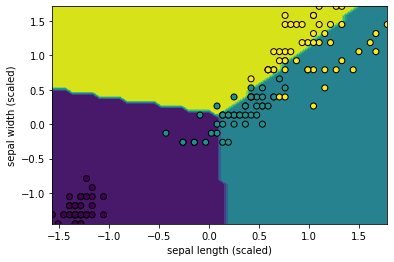

30 - 25


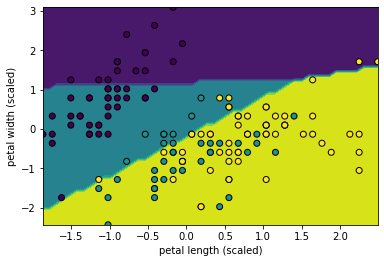

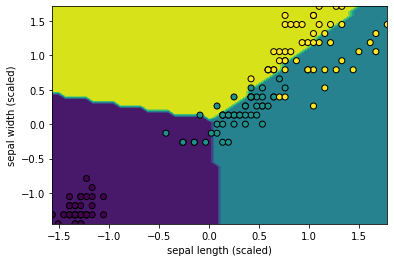

Evaluate TessarineTwoLayer


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.46      0.75      0.57         8
           2       0.67      0.25      0.36         8

    accuracy                           0.70        30
   macro avg       0.69      0.64      0.62        30
weighted avg       0.73      0.70      0.68        30

20 - 25


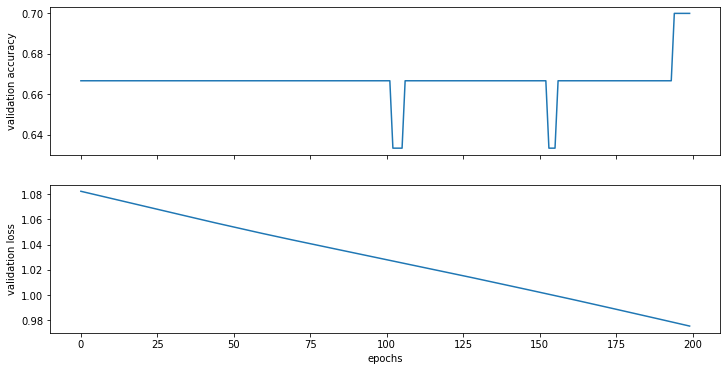

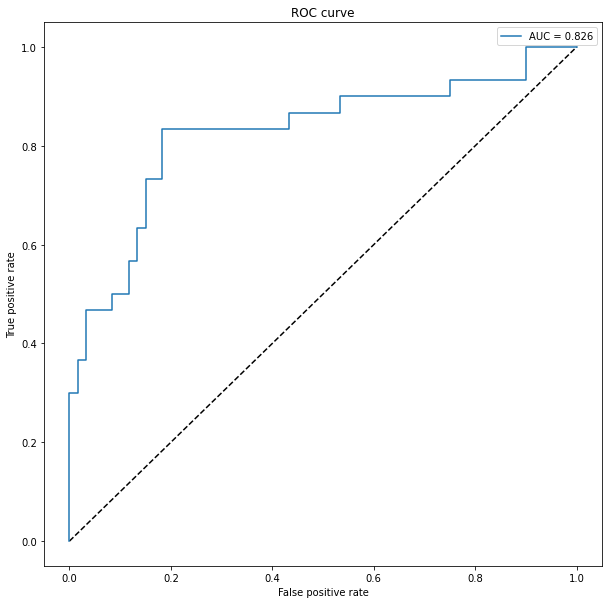

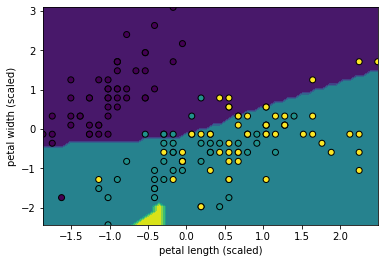

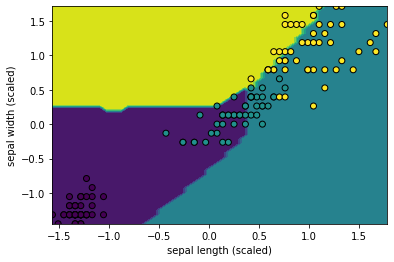

23 - 24


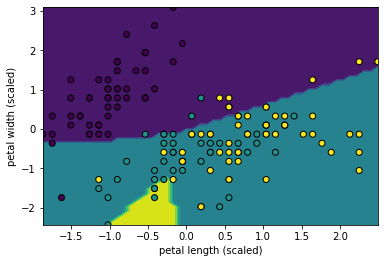

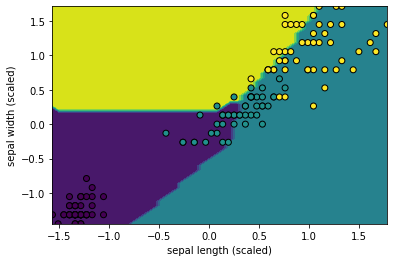

25 - 26


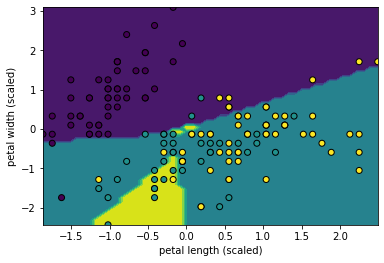

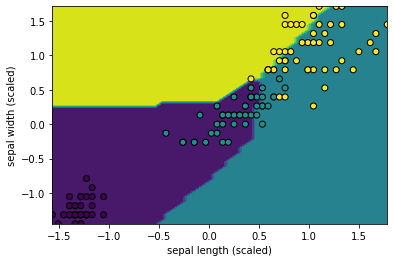

30 - 25


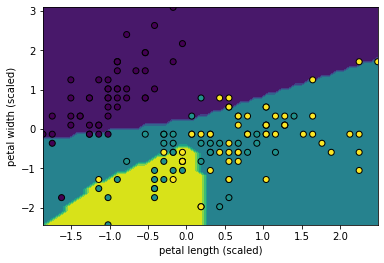

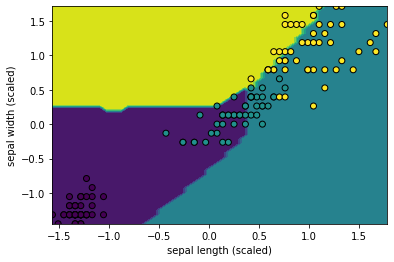

Evaluate Tessarine3MLP


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.75      0.75      0.75         8
           2       0.78      0.88      0.82         8

    accuracy                           0.87        30
   macro avg       0.84      0.85      0.85        30
weighted avg       0.87      0.87      0.87        30

20 - 25


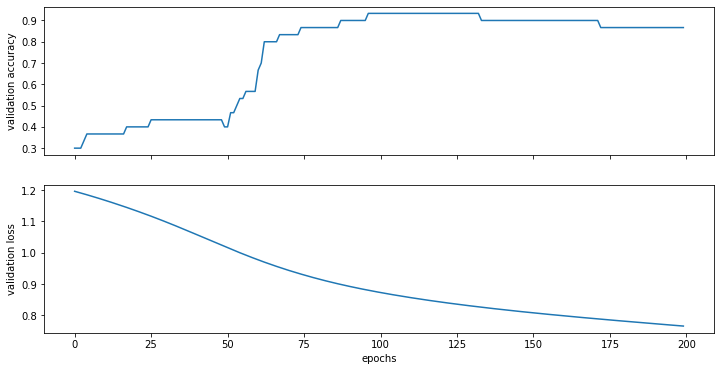

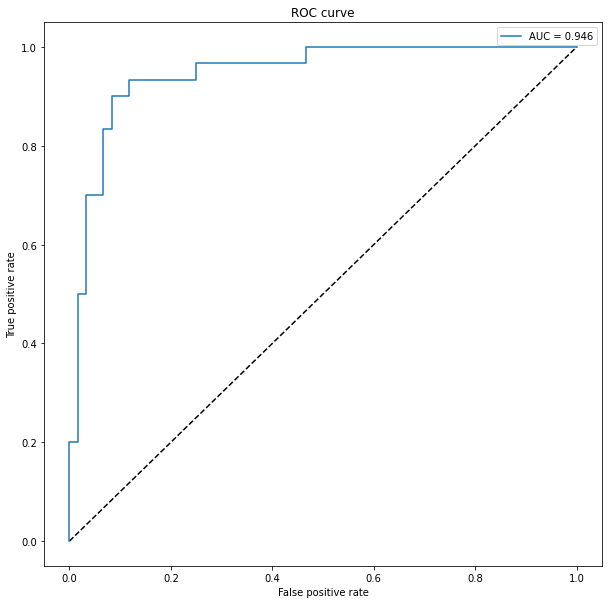

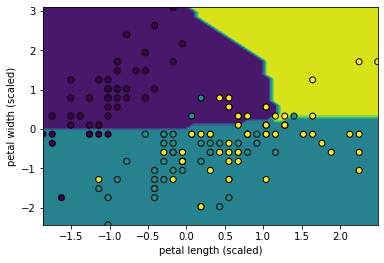

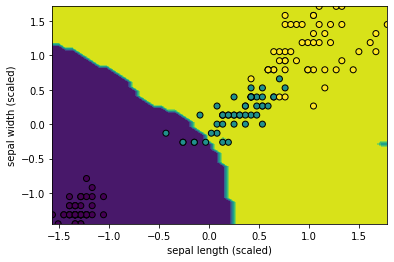

23 - 24


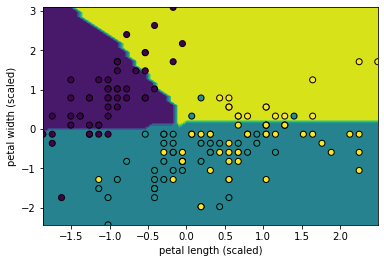

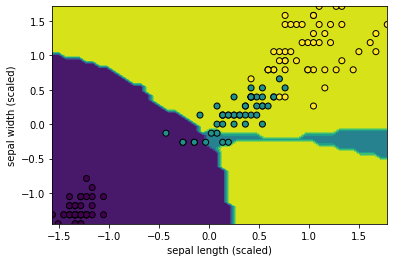

25 - 26


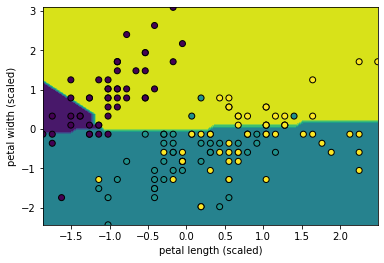

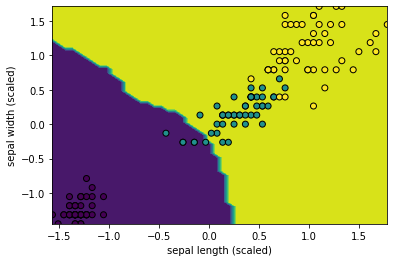

30 - 25


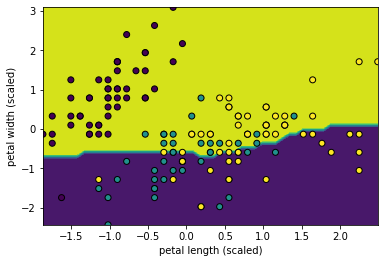

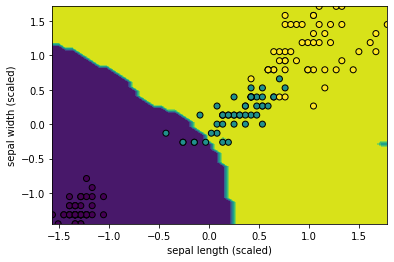

In [47]:
def tessarrine_linear(input, r_weight, i_weight, j_weight, k_weight, bias=True):
    # to simulate the hamiltonian product
    cat_kernels_4_r = torch.cat([r_weight, i_weight, -j_weight, -k_weight], dim=0)
    cat_kernels_4_i = torch.cat([i_weight,  r_weight, -k_weight, -j_weight], dim=0)
    cat_kernels_4_j = torch.cat([j_weight,  k_weight, r_weight, -i_weight], dim=0)
    cat_kernels_4_k = torch.cat([k_weight,  j_weight, i_weight, r_weight], dim=0)
    cat_kernels_4_quaternion = torch.cat([cat_kernels_4_r, cat_kernels_4_i, cat_kernels_4_j, cat_kernels_4_k], dim=1)

    if input.dim() == 2:
        if bias is not None:
            return torch.addmm(bias, input, cat_kernels_4_quaternion)
        else:
            return torch.mm(input, cat_kernels_4_quaternion)
    else:
        output = torch.matmul(input, cat_kernels_4_quaternion)
        if bias is not None:
            return output+bias
        else:
            return output

class TessarineLinear(Module):
    def __init__(self, in_features, out_features, bias=True, init_criterion='he', weight_init='quaternion', seed=None):
        super(TessarineLinear, self).__init__()
        self.in_features  = in_features//4
        self.out_features = out_features//4
        self.r_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.i_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.j_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.k_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))

        if bias:
            self.bias     = Parameter(torch.Tensor(self.out_features*4))
        else:
            self.register_parameter('bias', None)

        self.init_criterion = init_criterion
        self.weight_init    = weight_init
        self.seed           = seed if seed is not None else np.random.randint(0,1234)
        self.rng            = RandomState(self.seed)
        self.reset_parameters()

    def reset_parameters(self):
        winit = {'quaternion': quaternion_init,
                 'unitary': unitary_init}[self.weight_init]
        if self.bias is not None:
            self.bias.data.fill_(0)
        affect_init(self.r_weight, self.i_weight, self.j_weight, self.k_weight, winit,
                    self.rng, self.init_criterion)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        if input.dim() == 3:
            raise NotImplementedError
            # T, N, C = input.size()
            # input  = input.view(T * N, C)
            # output = QuaternionLinearFunction.apply(input, self.r_weight, self.i_weight, self.j_weight, self.k_weight, self.bias)
            # output = output.view(T, N, output.size(1))
        elif input.dim() == 2:
            output = tessarrine_linear(input, self.r_weight, self.i_weight, self.j_weight, self.k_weight, self.bias)
        else:
            raise NotImplementedError

        return output

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_features=' + str(self.in_features) \
            + ', out_features=' + str(self.out_features) \
            + ', bias=' + str(self.bias is not None) \
            + ', init_criterion=' + str(self.init_criterion) \
            + ', weight_init=' + str(self.weight_init) \
            + ', seed=' + str(self.seed) + ')'

class TessarineOneNeuron(nn.Module):
    def __init__(self, input_dim):
        super(TessarineOneNeuron, self).__init__()
        self.layer1 = TessarineLinear(input_dim, 4, bias=True)
        self.layer1.reset_parameters()
        
    def forward(self, x):
        x = F.softmax(self.layer1(x), dim=1)
        return x[:, 1:]

class TessarineTwoLayer(nn.Module):
    def __init__(self, input_dim):
        super(TessarineTwoLayer, self).__init__()
        self.layer1 = TessarineLinear(input_dim, 4, bias=True)
        self.layer2 = TessarineLinear(4, 4, bias=True)
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.softmax(self.layer2(x), dim=1)
        return x[:, 1:]

class Tessarine3MLP(nn.Module):
    def __init__(self, input_dim):
        super(Tessarine3MLP, self).__init__()
        self.layer1 = TessarineLinear(input_dim, 16, bias=True)
        self.layer2 = TessarineLinear(16, 16, bias=True)
        self.layer3 = TessarineLinear(16, 4, bias=True)
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()
        self.layer3.reset_parameters()
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x[:, 1:]

evaluate(TessarineOneNeuron)
evaluate(TessarineTwoLayer)
evaluate(Tessarine3MLP)

# HCA4

Evaluate HCA4OneNeuron


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.50      0.12      0.20         8
           2       0.50      0.88      0.64         8

    accuracy                           0.73        30
   macro avg       0.67      0.67      0.61        30
weighted avg       0.73      0.73      0.69        30

20 - 25


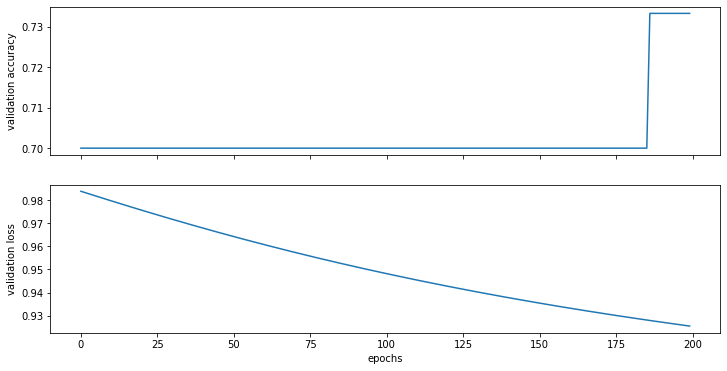

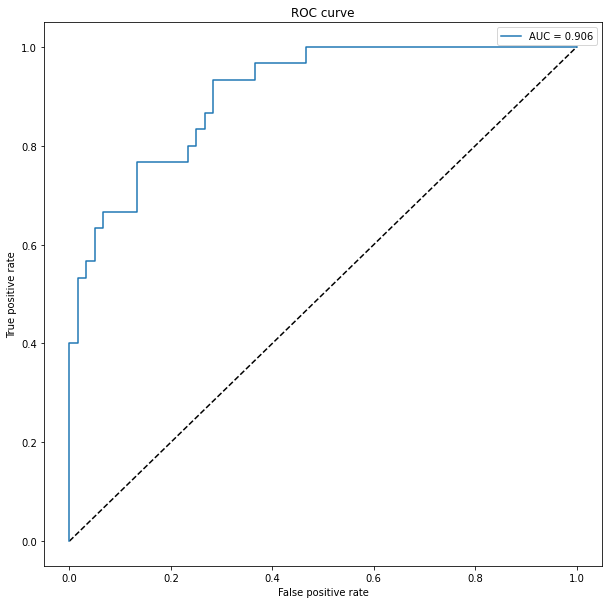

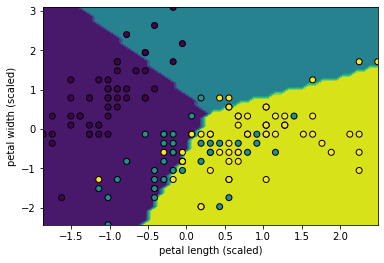

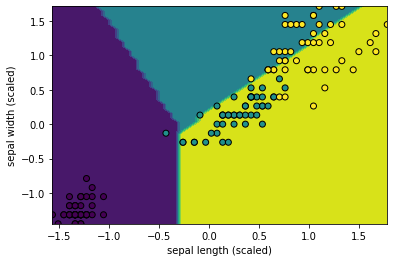

23 - 24


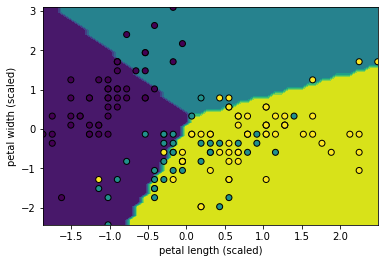

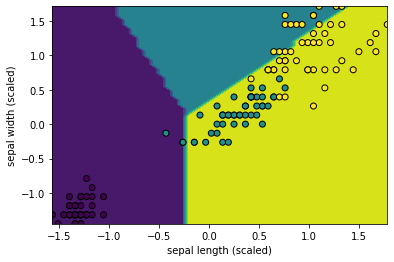

25 - 26


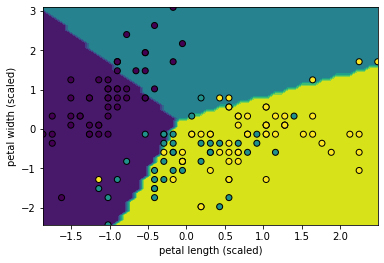

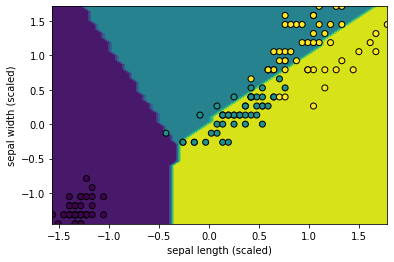

30 - 25


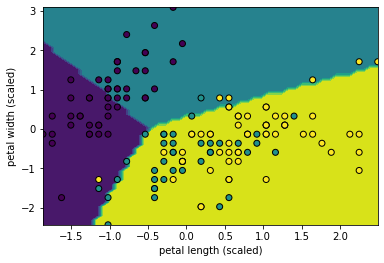

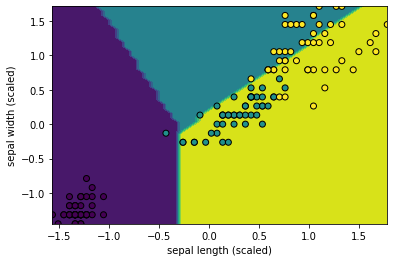

Evaluate HCA4TwoLayer


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00         8
           2       0.30      1.00      0.46         8

    accuracy                           0.27        30
   macro avg       0.10      0.33      0.15        30
weighted avg       0.08      0.27      0.12        30

20 - 25


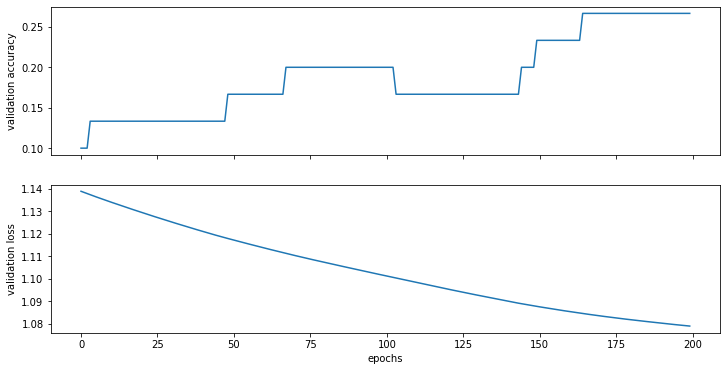

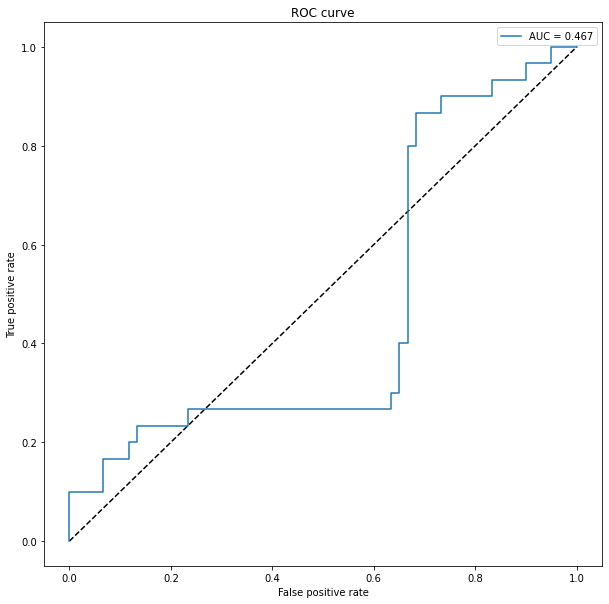

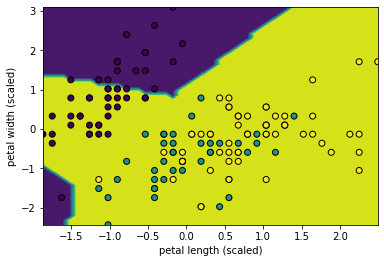

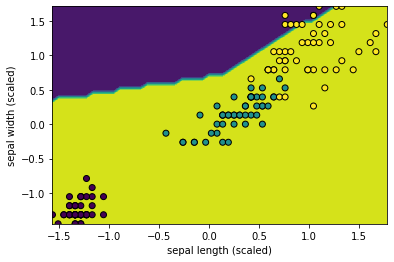

23 - 24


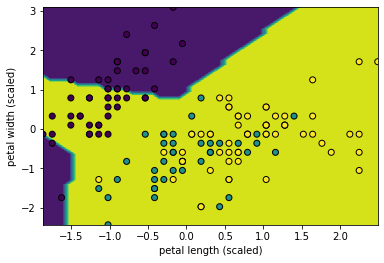

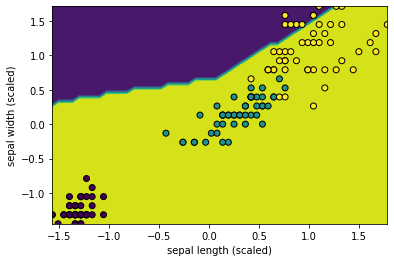

25 - 26


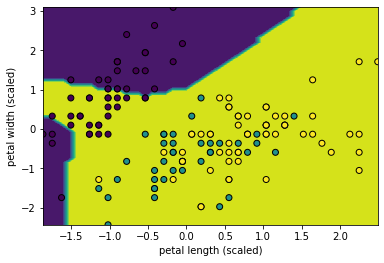

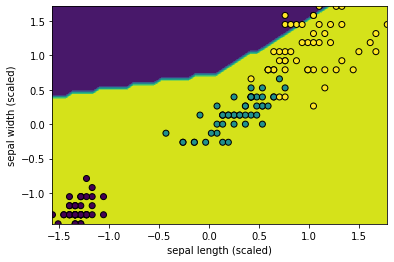

30 - 25


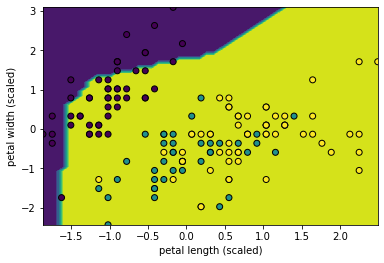

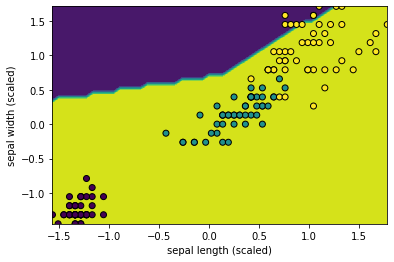

Evaluate HCA43MLP


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.71      0.62      0.67         8
           2       0.70      0.88      0.78         8

    accuracy                           0.83        30
   macro avg       0.80      0.81      0.80        30
weighted avg       0.84      0.83      0.83        30

20 - 25


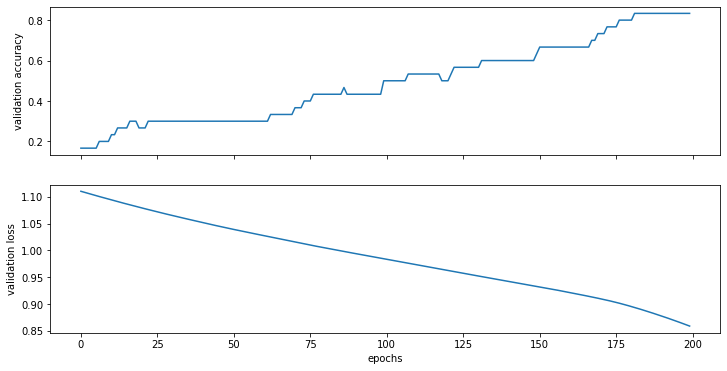

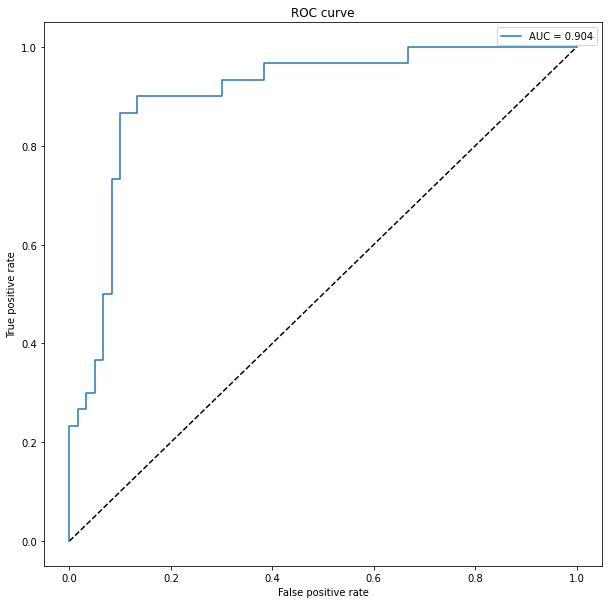

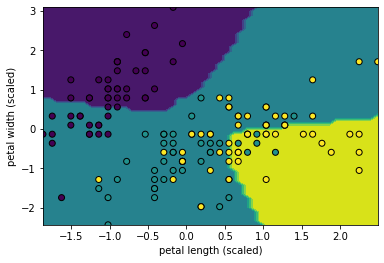

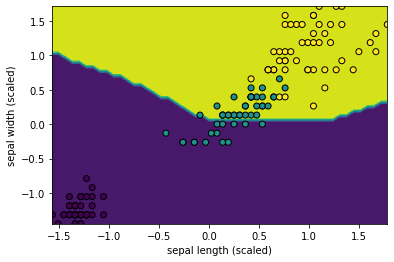

23 - 24


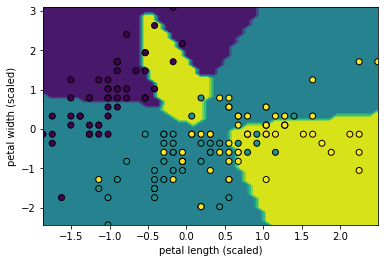

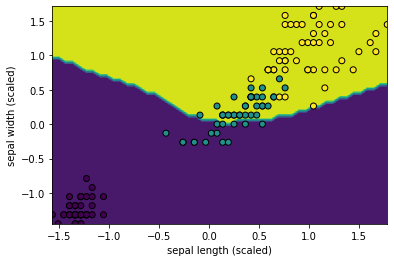

25 - 26


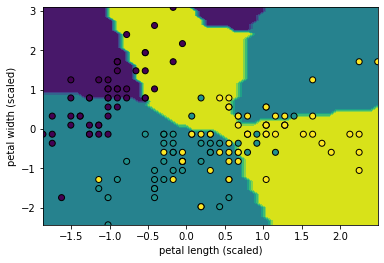

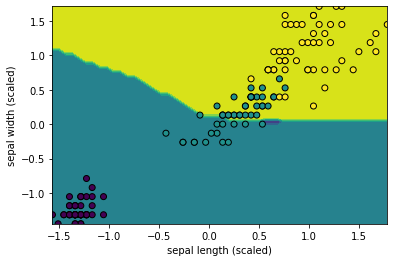

30 - 25


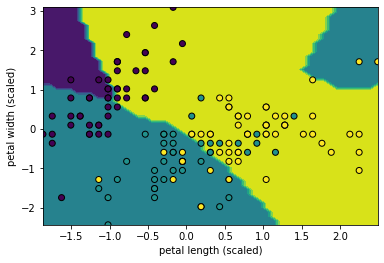

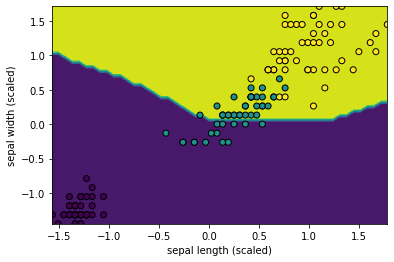

In [49]:
def hca4_linear(input, r_weight, i_weight, j_weight, k_weight, bias=True):
    # to simulate the hamiltonian product
    cat_kernels_4_r = torch.cat([r_weight, -i_weight, -j_weight, k_weight], dim=0)
    cat_kernels_4_i = torch.cat([i_weight,  r_weight, -k_weight, j_weight], dim=0)
    cat_kernels_4_j = torch.cat([j_weight,  k_weight, r_weight, -i_weight], dim=0)
    cat_kernels_4_k = torch.cat([k_weight,  -j_weight, -i_weight, r_weight], dim=0)
    cat_kernels_4_quaternion = torch.cat([cat_kernels_4_r, cat_kernels_4_i, cat_kernels_4_j, cat_kernels_4_k], dim=1)

    if input.dim() == 2:
        if bias is not None:
            return torch.addmm(bias, input, cat_kernels_4_quaternion)
        else:
            return torch.mm(input, cat_kernels_4_quaternion)
    else:
        output = torch.matmul(input, cat_kernels_4_quaternion)
        if bias is not None:
            return output+bias
        else:
            return output

class HCA4Linear(Module):
    def __init__(self, in_features, out_features, bias=True, init_criterion='he', weight_init='quaternion', seed=None):
        super(HCA4Linear, self).__init__()
        self.in_features  = in_features//4
        self.out_features = out_features//4
        self.r_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.i_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.j_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.k_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))

        if bias:
            self.bias     = Parameter(torch.Tensor(self.out_features*4))
        else:
            self.register_parameter('bias', None)

        self.init_criterion = init_criterion
        self.weight_init    = weight_init
        self.seed           = seed if seed is not None else np.random.randint(0,1234)
        self.rng            = RandomState(self.seed)
        self.reset_parameters()

    def reset_parameters(self):
        winit = {'quaternion': quaternion_init,
                 'unitary': unitary_init}[self.weight_init]
        if self.bias is not None:
            self.bias.data.fill_(0)
        affect_init(self.r_weight, self.i_weight, self.j_weight, self.k_weight, winit,
                    self.rng, self.init_criterion)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        if input.dim() == 3:
            raise NotImplementedError
            # T, N, C = input.size()
            # input  = input.view(T * N, C)
            # output = QuaternionLinearFunction.apply(input, self.r_weight, self.i_weight, self.j_weight, self.k_weight, self.bias)
            # output = output.view(T, N, output.size(1))
        elif input.dim() == 2:
            output = hca4_linear(input, self.r_weight, self.i_weight, self.j_weight, self.k_weight, self.bias)
        else:
            raise NotImplementedError

        return output

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_features=' + str(self.in_features) \
            + ', out_features=' + str(self.out_features) \
            + ', bias=' + str(self.bias is not None) \
            + ', init_criterion=' + str(self.init_criterion) \
            + ', weight_init=' + str(self.weight_init) \
            + ', seed=' + str(self.seed) + ')'

class HCA4OneNeuron(nn.Module):
    def __init__(self, input_dim):
        super(HCA4OneNeuron, self).__init__()
        self.layer1 = HCA4Linear(input_dim, 4, bias=True)
        self.layer1.reset_parameters()
        
    def forward(self, x):
        x = F.softmax(self.layer1(x), dim=1)
        return x[:, 1:]

class HCA4TwoLayer(nn.Module):
    def __init__(self, input_dim):
        super(HCA4TwoLayer, self).__init__()
        self.layer1 = HCA4Linear(input_dim, 4, bias=True)
        self.layer2 = HCA4Linear(4, 4, bias=True)
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.softmax(self.layer2(x), dim=1)
        return x[:, 1:]

class HCA43MLP(nn.Module):
    def __init__(self, input_dim):
        super(HCA43MLP, self).__init__()
        self.layer1 = HCA4Linear(input_dim, 16, bias=True)
        self.layer2 = HCA4Linear(16, 16, bias=True)
        self.layer3 = HCA4Linear(16, 4, bias=True)
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()
        self.layer3.reset_parameters()
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x[:, 1:]

evaluate(HCA4OneNeuron)
evaluate(HCA4TwoLayer)
evaluate(HCA43MLP)

# RQ

Evaluate HCA4OneNeuron


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.07      0.12      0.09         8
           2       0.00      0.00      0.00         8

    accuracy                           0.03        30
   macro avg       0.02      0.04      0.03        30
weighted avg       0.02      0.03      0.02        30

20 - 25


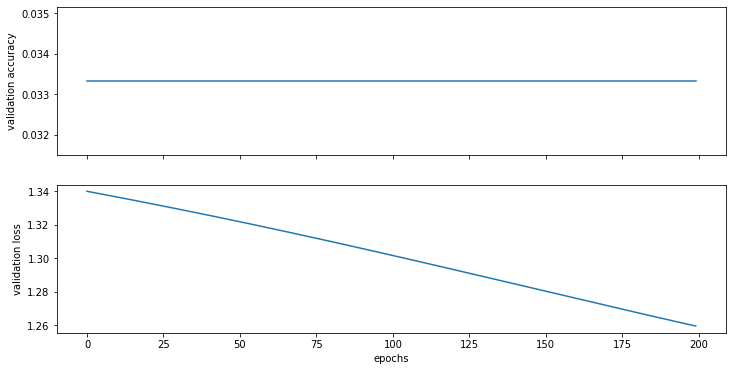

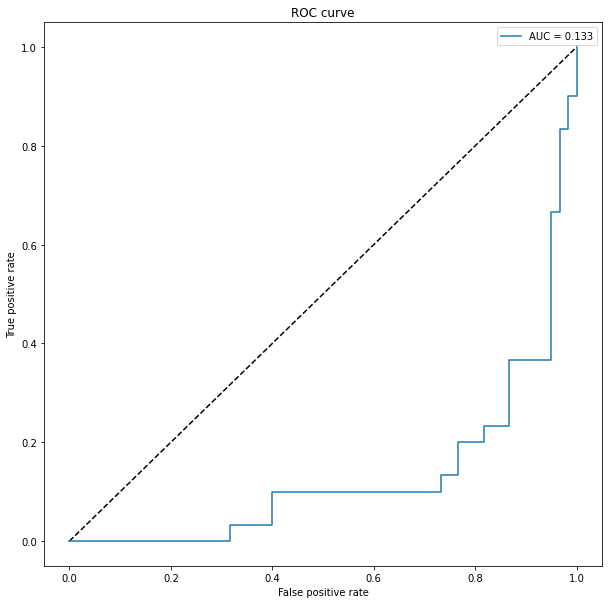

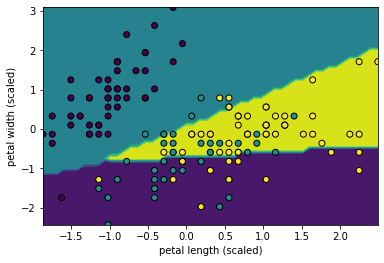

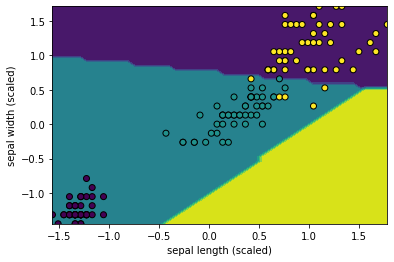

23 - 24


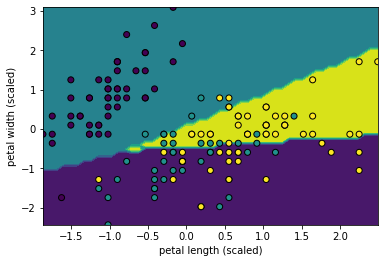

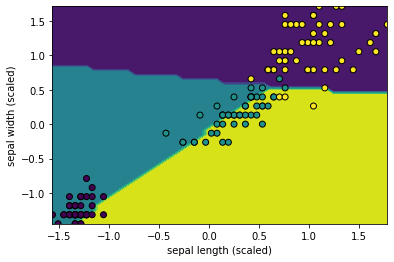

25 - 26


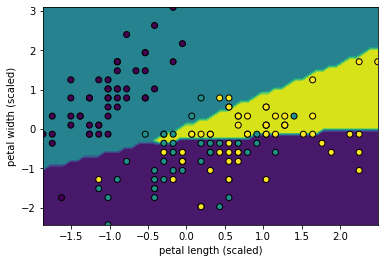

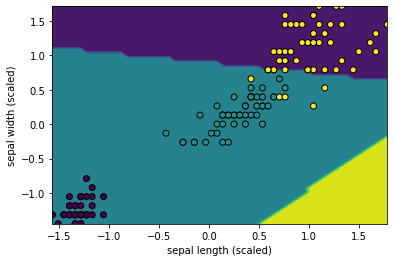

30 - 25


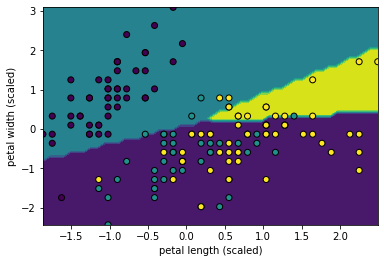

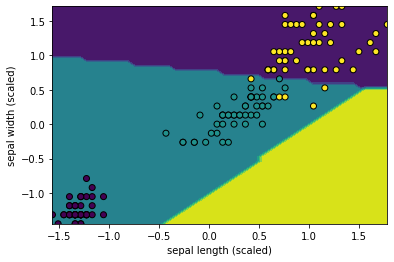

Evaluate HCA4TwoLayer


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.54      0.88      0.67         8
           2       0.67      0.25      0.36         8

    accuracy                           0.77        30
   macro avg       0.74      0.71      0.68        30
weighted avg       0.79      0.77      0.74        30

20 - 25


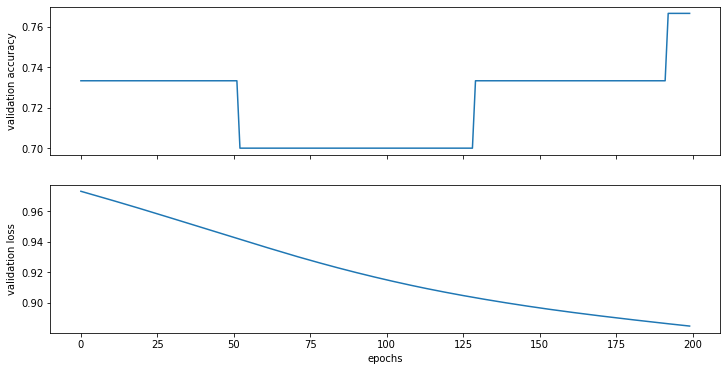

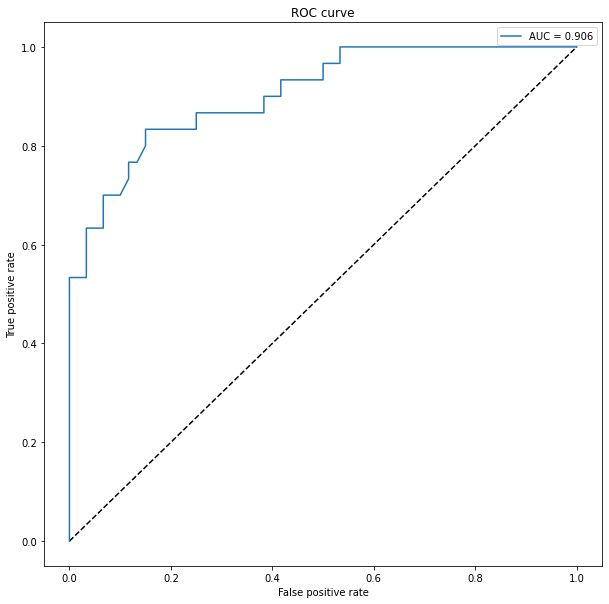

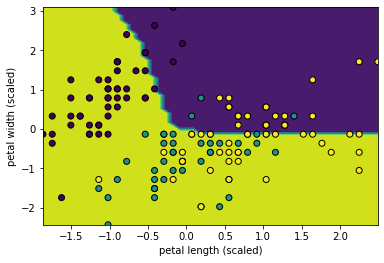

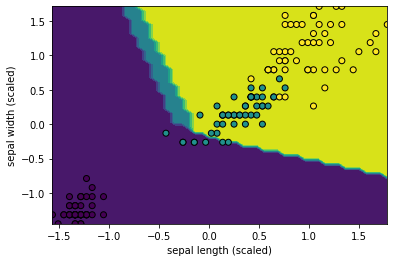

23 - 24


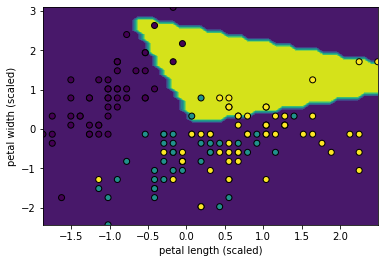

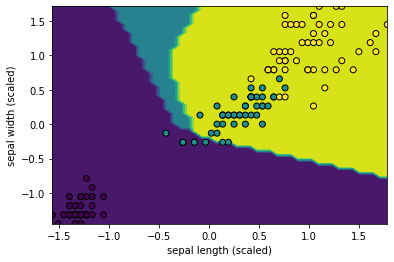

25 - 26


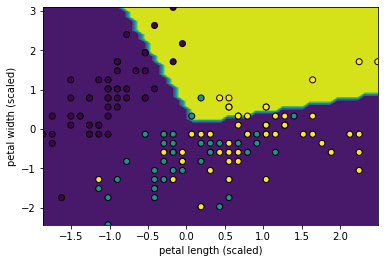

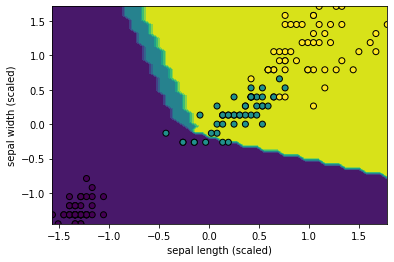

30 - 25


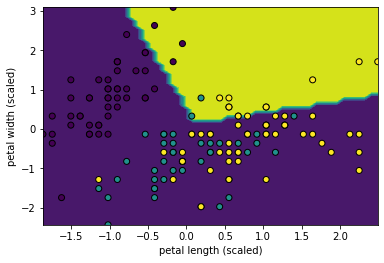

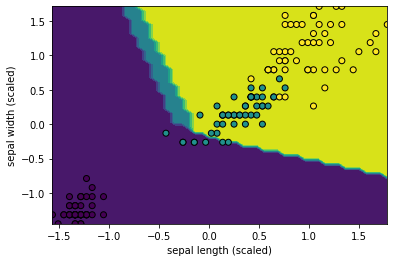

Evaluate HCA43MLP


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.67      0.50      0.57         8
           2       0.64      0.88      0.74         8

    accuracy                           0.80        30
   macro avg       0.77      0.77      0.76        30
weighted avg       0.81      0.80      0.80        30

20 - 25


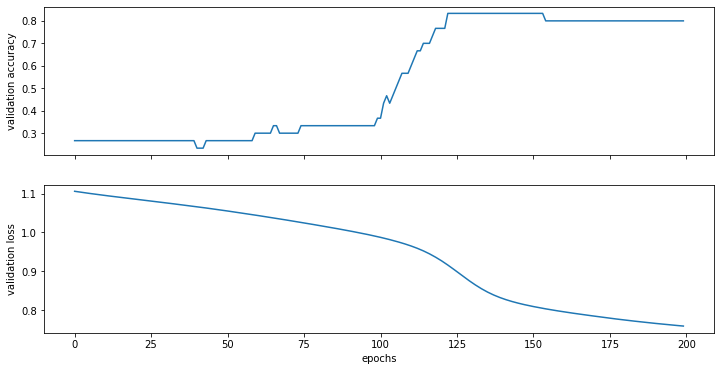

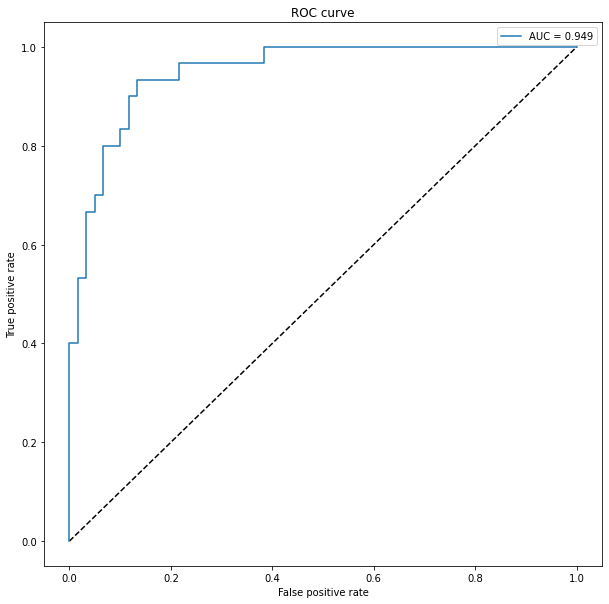

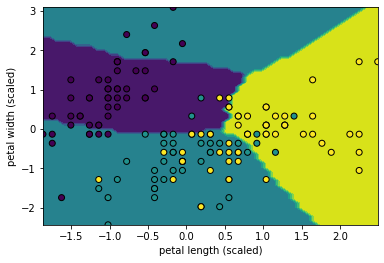

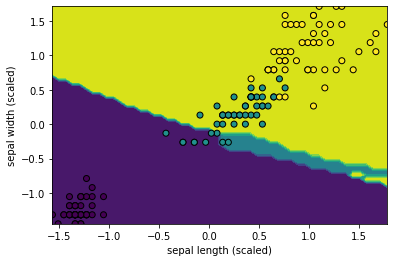

23 - 24


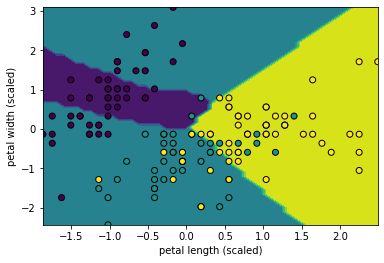

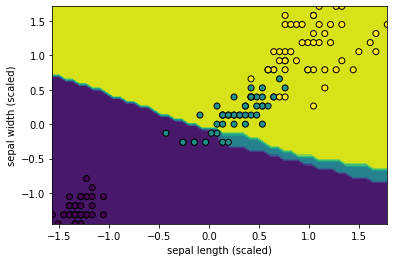

25 - 26


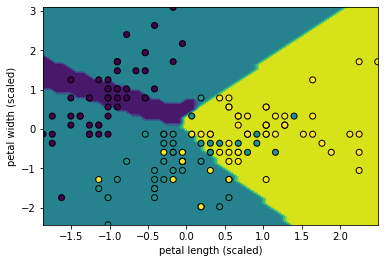

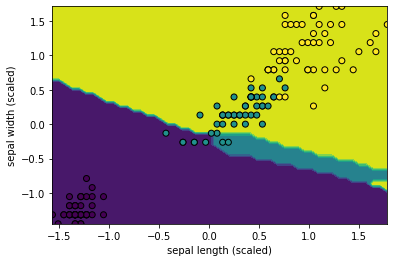

30 - 25


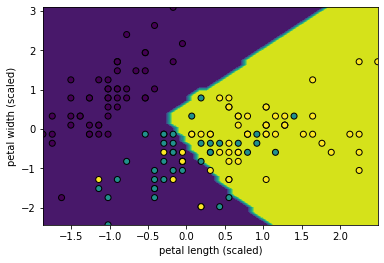

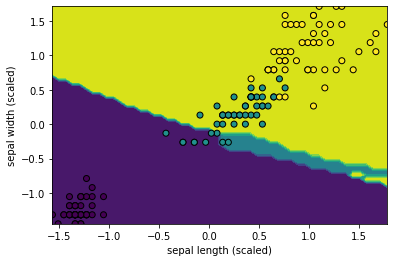

In [50]:
def rq_linear(input, r_weight, i_weight, j_weight, k_weight, bias=True):
    # to simulate the hamiltonian product
    cat_kernels_4_r = torch.cat([r_weight, -i_weight, j_weight, -k_weight], dim=0)
    cat_kernels_4_i = torch.cat([i_weight,  r_weight, k_weight, j_weight], dim=0)
    cat_kernels_4_j = torch.cat([j_weight,  -k_weight, r_weight, -i_weight], dim=0)
    cat_kernels_4_k = torch.cat([k_weight,  j_weight, i_weight, r_weight], dim=0)
    cat_kernels_4_quaternion = torch.cat([cat_kernels_4_r, cat_kernels_4_i, cat_kernels_4_j, cat_kernels_4_k], dim=1)

    if input.dim() == 2:
        if bias is not None:
            return torch.addmm(bias, input, cat_kernels_4_quaternion)
        else:
            return torch.mm(input, cat_kernels_4_quaternion)
    else:
        output = torch.matmul(input, cat_kernels_4_quaternion)
        if bias is not None:
            return output+bias
        else:
            return output

class RQLinear(Module):
    def __init__(self, in_features, out_features, bias=True, init_criterion='he', weight_init='quaternion', seed=None):
        super(RQLinear, self).__init__()
        self.in_features  = in_features//4
        self.out_features = out_features//4
        self.r_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.i_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.j_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.k_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))

        if bias:
            self.bias     = Parameter(torch.Tensor(self.out_features*4))
        else:
            self.register_parameter('bias', None)

        self.init_criterion = init_criterion
        self.weight_init    = weight_init
        self.seed           = seed if seed is not None else np.random.randint(0,1234)
        self.rng            = RandomState(self.seed)
        self.reset_parameters()

    def reset_parameters(self):
        winit = {'quaternion': quaternion_init,
                 'unitary': unitary_init}[self.weight_init]
        if self.bias is not None:
            self.bias.data.fill_(0)
        affect_init(self.r_weight, self.i_weight, self.j_weight, self.k_weight, winit,
                    self.rng, self.init_criterion)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        if input.dim() == 3:
            raise NotImplementedError
            # T, N, C = input.size()
            # input  = input.view(T * N, C)
            # output = QuaternionLinearFunction.apply(input, self.r_weight, self.i_weight, self.j_weight, self.k_weight, self.bias)
            # output = output.view(T, N, output.size(1))
        elif input.dim() == 2:
            output = hca4_linear(input, self.r_weight, self.i_weight, self.j_weight, self.k_weight, self.bias)
        else:
            raise NotImplementedError

        return output

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_features=' + str(self.in_features) \
            + ', out_features=' + str(self.out_features) \
            + ', bias=' + str(self.bias is not None) \
            + ', init_criterion=' + str(self.init_criterion) \
            + ', weight_init=' + str(self.weight_init) \
            + ', seed=' + str(self.seed) + ')'

class RQOneNeuron(nn.Module):
    def __init__(self, input_dim):
        super(RQOneNeuron, self).__init__()
        self.layer1 = RQLinear(input_dim, 4, bias=True)
        self.layer1.reset_parameters()
        
    def forward(self, x):
        x = F.softmax(self.layer1(x), dim=1)
        return x[:, 1:]

class RQTwoLayer(nn.Module):
    def __init__(self, input_dim):
        super(RQTwoLayer, self).__init__()
        self.layer1 = RQLinear(input_dim, 4, bias=True)
        self.layer2 = RQLinear(4, 4, bias=True)
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.softmax(self.layer2(x), dim=1)
        return x[:, 1:]

class RQ3MLP(nn.Module):
    def __init__(self, input_dim):
        super(RQ3MLP, self).__init__()
        self.layer1 = RQLinear(input_dim, 16, bias=True)
        self.layer2 = RQLinear(16, 16, bias=True)
        self.layer3 = RQLinear(16, 4, bias=True)
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()
        self.layer3.reset_parameters()
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x[:, 1:]

evaluate(RQOneNeuron)
evaluate(RQTwoLayer)
evaluate(RQ3MLP)

# SPIN

# PHM